In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy 

## Data L(k)

In [2]:
err_L = 0.5 * 2**0.5 # mm
err_f = 1            # Hz

print(err_L, err_f)

0.7071067811865476 1


In [3]:
data_air    = pd.read_excel("213.ods", engine='odf', usecols = "A, D:E, I:J, N:O, S:T, X:Y", sheet_name = 0)
# data_carbon = pd.read_excel("213.ods", engine='odf', usecols = "A, D:E, I:J, N:O, S:T, X:Y", sheet_name = 1)

f_air = np.array([
    2700,
    2998,
    3502,
    4042,
    4476
])

# f_carbon = np.array([])

In [4]:
def rename_cols(data, f):
    tuples = [
        ("f", "k"),
        # (str(f[i]), "l")
        # (str(f[i]), "L") ...
    ]
    for i in range(0, len(f)):
        tuples.append((str(f[i]), "l"))
        tuples.append((str(f[i]), "L"))

    data.columns = pd.MultiIndex.from_tuples(tuples)
    return data

In [5]:
data_air = rename_cols(data_air, f_air)
data_air

f   2700          2998          3502          4042        4476     
   k      l      L      l      L      l      L      l      L    l    L
0  0   13.0    0.0    7.0    0.0   25.0    0.0   34.0    0.0   14    0
1  1   76.0   63.0   65.0   58.0   75.0   50.0   77.0   43.0   52   38
2  2  140.0  127.0  122.0  115.0  124.0   99.0  120.0   86.0   90   76
3  3  205.0  192.0  180.0  173.0  174.0  149.0  162.0  128.0  129  115
4  4    NaN    NaN    NaN    NaN  224.0  199.0  205.0  171.0  167  153
5  5    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  206  192

In [6]:
def latex_fmt(i, f, names):
    tmp = {
        (str(f[i]), names['l']) : "{:.0f}",
        (str(f[i]), names['L']) : "{:.0f}",
    }
    return tmp

In [7]:
def print_data(data, f, filename):
    names = {'k' : r"$k$",
             'f' : r"$f$, Гц",
             'l' : r"$l$, мм",
             'L' : r"$L$, мм"
            }

    out_fmt = {(names['f'], names['k']) : "{:.0f}"}

    for i in range(0, len(f)):
        o_list = latex_fmt(i, f, names)
        out_fmt.update(o_list)

    latex = data.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt, na_rep = "")

    latex.to_latex(
                buf = filename,
                column_format="c" * data.shape[1],
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    return latex

In [8]:
print_data(data_air, f_air, "L_k_air.tex")
#print_data(data_carbon, f_carbon, "L_k_carbon.tex")


# Process L(k)

In [9]:
colour = ["red", "blue", "green", "yellow", "purple", "orange"]

def lin_plot_Lk(x, y, label = None, i = 1):
    coeffs = np.polyfit(x, y, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    
    x_space = np.linspace(0, max(x), 100)
    plt.plot(x_space, equ(x_space), label = label, c = colour[i])
    plt.errorbar(x, y, yerr=0.1, xerr=0, fmt='.', c = colour[i])
    

In [10]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

def least_sq(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

In [11]:
def plot_data(data, f, filename):
    a     = np.array([])      # a
    err_a = np.array([])      # errors a

    for i in range(0, len(f)):
        x = data[('f', 'k')]
        y = data[(str(f[i]), 'L')]

        df, dat = least_sq(x, y)
        latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
        print(latex)

        a     = np.append(a, dat[5])
        err_a = np.append(err_a, dat[6])

        label = r"$f = " + str(f[i]) + r"$ Гц"
        lin_plot_Lk(x, y, label, i)

    plt.title("$L \; (k)$")
    plt.ylabel(r"$L$ мм")
    plt.xlabel(r"$k$")
    plt.grid(True)
    plt.legend(fontsize = 8, framealpha = 0.1)

    print("Coeffs")
    print(a)
    print(err_a)
    plt.savefig(filename)
    
    return a, err_a

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
1.50e+00 & 1.25e+00 & 95.50 & 5.12e+03 & 8.00e+01 & 64.00 & 0.32 & -0.50 & 0.59 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
1.50e+00 & 1.25e+00 & 86.50 & 4.15e+03 & 7.20e+01 & 57.60 & 0.14 & 0.10 & 0.26 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
1.50e+00 & 1.25e+00 & 74.50 & 3.08e+03 & 6.20e+01 & 49.60 & 0.14 & 0.10 & 0.26 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
1.50e+00 & 1.25e+00 & 64.25 & 2.28e+03 & 5.34e+01 & 42.70 & 0.17 & 0.20 & 0.32 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\s

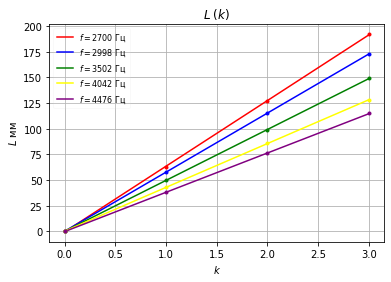

In [12]:
a_air, err_a_air = plot_data(data_air.dropna(), f_air, "L_k_air.pdf")

In [13]:
def print_processed(a, err_a, f, filename):
    lmd = 2 * a
    err_lmd = 2 * err_a

    c = lmd * f / 1000  # mm->m conversion
    err_c = c * ((err_lmd/lmd)**2 + (err_f/f)**2)**0.5

    processed = pd.DataFrame({'f'   : f,
                              'a'   : a,   'err_a'   : err_a,
                              'lmd' : lmd, 'err_lmd' : err_lmd,
                              'c'   : c,   'err_c'   : err_c,
                            })

    names = {
        'f'     : r"$f$, Гц",

        'a'     : r"$a$, мм",
        'err_a' : r"$\sigma_a$, мм",

        'lmd'       : r"$\lambda$, мм",
        'err_lmd'   : r"$\sigma_{\lambda}$, мм",

        'c'     : r"$c$, м/c",
        'err_c' : r"$\sigma_c$, м/с",
    }

    out_fmt = {
        names['f']     : "{:.0f}",

        names['a']     : "{:.1f}",
        names['err_a'] : "{:.1f}",

        names['lmd']       : "{:.1f}",
        names['err_lmd']   : "{:.1f}",

        names['c']     : "{:.1f}",
        names['err_c'] : "{:.1f}",
    }

    latex = processed.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
                buf = filename,
                column_format="c" * len(names),
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    
    # Evaluating results
    c_av = np.mean(c)
    err_c_av = 0

    for i in range(len(f)):
        err_c_av += (c[i] - c_av)**2

    err_c_av **= 0.5

    print("c_av:", c_av)
    print(err_c_av)

    mu = 0.02898
    T = 298

    gamma = mu/(8.31 * T) * c_av**2
    err_gamma = gamma * ((2 * err_c_av/c_av)**2 + (0.1/T)**2)**0.5

    print("gamma:", gamma)
    print(err_gamma)


In [14]:
print_processed(a_air, err_a_air, f_air, "processed_L_k_air.tex")

c_av: 345.28328000000005
3.2334714670150406
gamma: 1.395186259423127
0.02613517220737913


## Data F(k)

In [15]:
data = pd.read_excel("213.ods", engine='odf', usecols = "A, D:E, I:J, N:O, S:T, X:Y", sheet_name = 2)

T = np.array([
    303,
    310,
    317,
    323,
    328
])
err_T = 0.1

L = 740
err_L = 1

# f_carbon = np.array([])

In [16]:
def rename_cols(data, T):
    tuples = [
        ("T", "k"),
        # (str(f[i]), "l")
        # (str(f[i]), "L") ...
    ]
    for i in range(0, len(T)):
        tuples.append((str(T[i]), "f"))
        tuples.append((str(T[i]), "F"))

    data.columns = pd.MultiIndex.from_tuples(tuples)
    return data

In [17]:
data = rename_cols(data, T)
data

T   303         310         317         323         328      
   k     f     F     f     F     f     F     f     F     f     F
0  0   712     0   255     0   253     0   258     0   260     0
1  1   941   229   489   234   493   240   488   230   496   236
2  2  1171   459   718   463   725   472   732   474   731   471
3  3  1410   698   944   689   963   710   971   713   977   717
4  4  1640   928  1185   930  1201   948  1203   945  1216   956
5  5  1875  1163  1423  1168  1436  1183  1450  1192  1463  1203
6  6  2106  1394  1657  1402  1677  1424  1697  1439  1697  1437
7  7  2337  1625  1897  1642  1917  1664  1937  1679  1950  1690

In [18]:
def latex_fmt(i, T, names):
    tmp = {
        (str(T[i]), names['f']) : "{:.0f}",
        (str(T[i]), names['F']) : "{:.0f}",
    }
    return tmp

In [19]:
def print_data(data, T, filename):
    names = {'k' : r"$k$",
             'T' : r"$T, ^{\circ} C$",
             'f' : r"$f$, Гц",
             'F' : r"$F$, Гц"
            }

    out_fmt = {(names['T'], names['k']) : "{:.0f}"}

    for i in range(0, len(T)):
        o_list = latex_fmt(i, T, names)
        out_fmt.update(o_list)

    latex = data.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt, na_rep = "")

    latex.to_latex(
                buf = filename,
                column_format="c" * data.shape[1],
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    return latex

In [20]:
print_data(data, T, "F_k.tex")


# Process F(k)

In [21]:
colour = ["red", "blue", "green", "yellow", "purple", "orange"]

def lin_plot_Fk(x, y, label = None, i = 1):
    coeffs = np.polyfit(x, y, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    
    x_space = np.linspace(0, max(x), 100)
    plt.plot(x_space, equ(x_space), label = label, c = colour[i])
    plt.errorbar(x, y, yerr=0.1, xerr=0, fmt='.', c = colour[i])
    

In [22]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

def least_sq(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

In [23]:
def plot_data(data, T, filename):
    a     = np.array([])      # a
    err_a = np.array([])      # errors a

    for i in range(0, len(T)):
        x = data[('T', 'k')]
        y = data[(str(T[i]), 'F')]

        df, dat = least_sq(x, y)
        latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
        print(latex)

        a     = np.append(a, dat[5])
        err_a = np.append(err_a, dat[6])

        label = r"$T = " + str(T[i]) + r" ^{\circ} C$"
        lin_plot_Lk(x, y, label, i)

    plt.title("$F \; (k)$")
    plt.ylabel(r"$F$, Гц")
    plt.xlabel(r"$k$")
    plt.grid(True)
    plt.legend(fontsize = 8, framealpha = 0.1)

    print("Coeffs")
    print(a)
    print(err_a)
    plt.savefig(filename)
    
    return a, err_a

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
3.50e+00 & 5.25e+00 & 812.00 & 2.84e+05 & 1.22e+03 & 232.64 & 0.37 & -2.25 & 1.55 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
3.50e+00 & 5.25e+00 & 816.00 & 2.88e+05 & 1.23e+03 & 234.40 & 0.83 & -4.42 & 3.49 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
3.50e+00 & 5.25e+00 & 830.12 & 2.96e+05 & 1.25e+03 & 237.37 & 0.39 & -0.67 & 1.63 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
3.50e+00 & 5.25e+00 & 834.00 & 3.03e+05 & 1.26e+03 & 240.29 & 0.86 & -7.00 & 3.58 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overlin

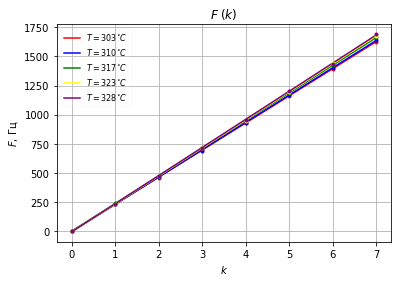

In [24]:
a, err_a = plot_data(data.dropna(), T, "F_k.pdf")

In [25]:
def print_processed(a, a_err, f, filename):
    
    c = 2 * a * L / 1000  # mm->m conversion
    err_c = c * ((err_a/a)**2 + (err_L/L)**2)**0.5
    mu = 0.02898
    gamma = mu / (8.31 * T) * c**2
    err_gamma = ((2 * err_c/c)**2 + (err_T/T)**2)
    
    processed = pd.DataFrame({'T'   : T,
                              'a'   : a,   'err_a'   : err_a,
                              'c'   : c,   'err_c'   : err_c,
                              'gamma': gamma, 'err_gamma' : err_gamma
                            })

    names = {
        'T'     : r"$T, \;^{circ} C$",

        'a'     : r"$a, \; \text{c}^{-1}",
        'err_a' : r"$\sigma_a \; \text{c}^{-1}$, c^{-1}",

        'c'     : r"$c$, м/c",
        'err_c' : r"$\sigma_c$, м/с",
        
        'gamma' : r"$\gamma$",
        'err_gamma' : r"$\sigma_{\gamma}$"
    }

    out_fmt = {
        names['T']     : "{:.1f}",

        names['a']     : "{:.1f}",
        names['err_a'] : "{:.1f}",

        names['c']     : "{:.1f}",
        names['err_c'] : "{:.1f}",

        names['gamma']       : "{:.3f}",
        names['err_gamma']   : "{:.3f}",
    }

    latex = processed.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
                buf = filename,
                column_format="c" * len(names),
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    
    # Evaluating results
    gamma_av = np.mean(gamma)
    err_gamma_av = 0

    for i in range(len(f)):
        err_gamma_av += (gamma[i] - gamma_av)**2

    err_gamma_av **= 0.5

    print("gamma_av:", gamma_av)
    print(err_gamma_av)


In [26]:
print_processed(a, err_a, T, "processed_F_k.tex")

gamma_av: 1.3595285782838165
0.010279018929295124
